# 04.1 Many Hidden Units

Like notebook 4, except I'm going to save the data, and I'm also going to run the number of hidden units from 1 to 100. 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import pandas as pd

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'
from random import shuffle
import sys
import pickle

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''

        #this LSTM goes from input [batch x length x 1] to output [batch x length x hidden]
        self.lstm = nn.LSTM(1, hidden, batch_first=True).double().cuda() 

        #this matrix transforms from [1 x hidden] to [1 x 1]
        self.combine = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.lstm.parameters())
        params.append(self.combine)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.
        Shape: [batch x length x 1]'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the actual sum of the tensor. 
        Returns the loss and the predicted sum'''
        pred, _ = self.lstm(sequence)
        pred = pred[:,-1,:] @ self.combine 
        #the second index is the rolling output. The final output is the last element in that index

        loss = (pred - sequence.sum(1)).pow(2)
        return loss, pred

    def predict_multilength(self, sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        count= torch.tensor(0, device=device).double()
        for s in sequences:
            pred = self.predict(s)[0]
            count += pred.shape[0]
            loss += pred.sum()
        return loss / count

## Model Testing

In [0]:
def round_partition(p):
    '''Rounds a partition so that the sum of the partition equals the original sum'''
    rounded = np.round(p).astype(int)
    ind = len(rounded)-1
    while rounded.sum() < p.sum():
        rounded[ind] += 1
        ind -= 1
    return rounded

def generate_data(length, total):
    counts = np.random.dirichlet((np.arange(length)+1)**2) * total * 0.9
    counts = round_partition(counts)

    train_set = []
    val_set = []
    test_set = []
    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i-1],i])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            train = Counter.convert_sequence(seqs)
            train_set.append(train)
            continue
    counts = np.random.dirichlet((np.arange(length, 2*length)+1)**2) * total * 0.1
    counts = round_partition(counts)

    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i],i+length+1])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        seqs = Counter.convert_sequence(seqs)
        test_set.append(seqs)

    return train_set, val_set, test_set

In [0]:
#generate all the strings and partition into train and test
length = 64
hidden = 10
depth = 100000

output_folder = "Part-4.1-Outputs"

In [0]:
# train, val, test = generate_data(length,depth)

# with open("%s/Data.pickle"%output_folder, "wb") as f:
#     pickle.dump([train, val, test], f)

In [0]:
with open("%s/Data.pickle"%output_folder, "rb") as f:
    train, val, test = pickle.load(f)

In [0]:
trainsize = sum([x.shape[0] for x in train])
valsize = sum([x.shape[0] for x in val])
testsize = sum([x.shape[0] for x in test])
print(trainsize, valsize, testsize)

total = trainsize+valsize+testsize
print("Total:",total) 
print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))

print("Train    string range: %d-%d"%(min([x.shape[1] for x in train]), max([x.shape[1] for x in train])))
print("Validate string range: %d-%d"%(min([x.shape[1] for x in val]), max([x.shape[1] for x in val])))
print("Test     string range: %d-%d"%(min([x.shape[1] for x in test]), max([x.shape[1] for x in test])))

6976 2025 1002
Total: 10003
Fraction 0.697 0.202 0.100
Train    string range: 3-64
Validate string range: 4-64
Test     string range: 65-128


## Model Training

In [0]:
model = Counter(hidden)

history = []
best = float('inf')
patience = 10
tol = 0.001
count = 0

for epoch in range(1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 100 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f"%(epoch, train_loss, val_loss))

        if val_loss + tol < best:
            best = val_loss
            count = 0
            torch.save(model, "%s/Model-%d"%(output_folder, hidden))

        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

#display testing results
loss = model.predict_multilength(test)
print("Average Test Loss:", loss.item())

history = np.array(history)
np.save("%s/Train-%d"%(output_folder, hidden), history)


## Results

In [0]:
hidden = []
models = []
res = []
for h in [1,5,10,25,50,100]:
    model = torch.load(f"{output_folder}/Model-{h}")
    models.append(model)
    hidden.append(h)
    train_loss = model.predict_multilength(train).item()
    val_loss = model.predict_multilength(val).item()
    test_loss = model.predict_multilength(test).item()
    res.append([h, train_loss, val_loss, test_loss])

In [0]:
pd.DataFrame(res)

,0,1,2,3
0,1,0.021538,0.024680,134.965137
1,5,0.017260,0.019312,178.019121
2,10,0.005695,0.007728,175.546043
3,25,0.006479,0.006928,174.814449
4,50,0.005991,0.006335,165.398288
5,100,0.040560,0.044631,168.567407


In [0]:
evals = []

In [0]:
for length in range(2,500):
    s = np.random.randint(0,2,size=(1,length, 1))
    s = torch.tensor(s).double().cuda()
    e = [length, s.sum(1).item()]
    for m in models:
        e.append(m.predict(s)[1].item())
    evals.append(e)

In [0]:
ev = pd.DataFrame(evals, columns=["Length", "Sum", "1 Units","5 Units","10 Units","25 Units","50 Units","100 Units"])
ev = ev.melt(id_vars=["Length","Sum"], var_name="Hidden Units", value_name="Prediction")

In [0]:
count = [torch.max(x.sum(1)).item() for x in train]
count = np.array(count)
count = np.max(count)
print(count)

46.0


In [0]:
other = pd.read_csv("Part-4.2-Outputs/Testing-4.2")

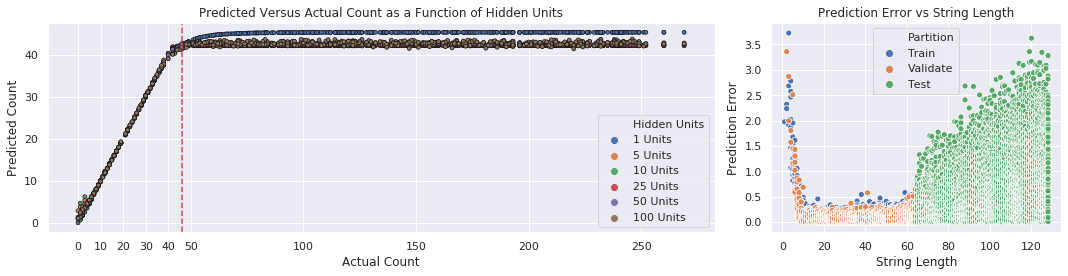

In [0]:
sns.set()
plt.figure(figsize=(15,4))
gs = GridSpec(1,2, width_ratios=[2.3,1])
plt.subplot(gs[0]) 
plt.axvline(count,linestyle='--', color='r')
sns.scatterplot(x="Sum", y="Prediction", hue="Hidden Units", data=ev, edgecolor='k', s=15)
plt.xticks(list(range(0,50,10))+list(range(50,300,50)))
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Predicted Versus Actual Count as a Function of Hidden Units")

plt.subplot(gs[1])
sns.set()
sns.scatterplot(x="Length", y="Error", data=other, hue='Partition')
plt.xlabel("String Length")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs String Length")
plt.tight_layout()
plt.savefig('Figures/04-plot1', dpi=300)